In [3]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/Colab Notebooks

!pip install mne

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks
     |████████████████████████████████| 6.3MB 6.4MB/s 
  Created wheel for mne: filename=mne-0.18.2-cp36-none-any.whl size=6316007 sha256=ad4618616c3ef17bfaf8812c91528655220146cc16535b079e137ad911e2ab23
  Stored in directory: /root/.cache/pip/wheels/71/40/30/fb9a9bdeac02c6b3b144be66ac345c5b5587a7d7610564535b
Successfully built mne


In [0]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0" #model will be trained on GPU 0
import numpy as np
from numpy.random import seed
seed(1)
from utils import load_subject_eeg, eeg_to_3d, balanced_subsample, reverse_coeffs 

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import pandas as pd

import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from keras.models import Model
from keras.optimizers import RMSprop
from keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose, LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K
from keras.utils import to_categorical
import tensorflow as tf

import pickle
import mne

In [0]:
words_file = 'raw_array_ica.pickle'
with open(words_file, 'rb') as f:
            file = pickle.load(f)
data = file['raw_array'][:][0]
labels = file['labels']
epoch = 4096
n_chan = len(data)
data_type = 'words'
data = eeg_to_3d(data, epoch, int(data.shape[1] / epoch), n_chan).astype(np.float32)
labels = labels.astype(np.int64)

data = data[:,:,768:1280]
labels[:] = [x - 6 for x in labels] 


In [458]:
train_data = data.reshape(-1, 6,512, 1).astype(np.float32)
train_data, test_data, train_label, test_label = train_test_split(train_data, labels, test_size=0.2, random_state=13)
train_data.shape, test_data.shape, train_label.shape, test_label.shape

((243, 6, 512, 1), (61, 6, 512, 1), (243,), (61,))

In [0]:
train_X,valid_X,train_ground,valid_ground = train_test_split(train_data,
                                                             train_data,
                                                             test_size=0.2,
                                                             random_state=13)


In [0]:
batch_size = 64
epochs = 100
inChannel = 1
x, y = 6, 512
input_img = Input(shape = (x, y, inChannel))
num_classes = 6

In [0]:
def encoder(input_img):
    
    conv1 = Conv2D(32, (3,3), padding='same')(input_img)
    conv1 = LeakyReLU()(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Dropout(rate=0.2)(conv1)
    conv1 = Conv2D(32, (3, 3), padding='same')(conv1)
    conv1 = LeakyReLU()(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), padding='same')(pool1) #14 x 14 x 64
    conv2 = LeakyReLU()(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Dropout(rate=0.2)(conv2)
    conv2 = Conv2D(64, (3, 3), padding='same')(conv2)
    conv2 = LeakyReLU()(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), padding='same')(pool2) #7 x 7 x 128 (small and thick)
    conv3 = LeakyReLU()(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Dropout(rate=0.2)(conv3)
    conv3 = Conv2D(128, (3, 3), padding='same')(conv3)
    conv3 = LeakyReLU()(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(256, (3, 3), padding='same')(conv3) #7 x 7 x 256 (small and thick)
    conv4 = LeakyReLU()(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Dropout(rate=0.5)(conv4)
    conv4 = Conv2D(256, (3, 3), padding='same')(conv4)
    conv4 = LeakyReLU()(conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4

def decoder(conv4):    
    #decoder
    conv5 = Conv2D(128, (3, 3), padding='same')(conv4) #7 x 7 x 128
    conv5 = LeakyReLU()(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(128, (3, 3), padding='same')(conv5)
    conv5 = LeakyReLU()(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Dropout(rate=0.5)(conv5)
    conv6 = Conv2D(64, (3, 3), padding='same')(conv5) #7 x 7 x 64
    conv6 = LeakyReLU()(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Dropout(rate=0.5)(conv6)
    conv6 = Conv2D(64, (3, 3), padding='same')(conv6)
    conv6 = LeakyReLU()(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Dropout(rate=0.5)(conv6)
    up1 = UpSampling2D((2,2))(conv6) #14 x 14 x 64
    conv7 = Conv2D(32, (3, 3), padding='same')(up1) # 14 x 14 x 32
    conv7 = LeakyReLU()(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(32, (3, 3), padding='same')(conv7)
    conv7 = LeakyReLU()(conv7)
    conv7 = BatchNormalization()(conv7)
    up2 = UpSampling2D((3,2))(conv7) # 28 x 28 x 32
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded
  
def fc(enco):
  flat = Flatten()(enco)
  den = Dense(128, activation='relu')(flat)
  out = Dense(num_classes, activation='softmax')(den)
  return out

In [489]:
autoencoder = Model(input_img, decoder(encoder(input_img)))
autoencoder.compile(loss='mean_squared_error', optimizer = Adam(lr=0.0001)) #0.0001
autoencoder.summary()

Model: "model_68"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_43 (InputLayer)        (None, 6, 512, 1)         0         
_________________________________________________________________
conv2d_831 (Conv2D)          (None, 6, 512, 32)        320       
_________________________________________________________________
leaky_re_lu_404 (LeakyReLU)  (None, 6, 512, 32)        0         
_________________________________________________________________
batch_normalization_721 (Bat (None, 6, 512, 32)        128       
_________________________________________________________________
dropout_105 (Dropout)        (None, 6, 512, 32)        0         
_________________________________________________________________
conv2d_832 (Conv2D)          (None, 6, 512, 32)        9248      
_________________________________________________________________
leaky_re_lu_405 (LeakyReLU)  (None, 6, 512, 32)        0  

In [474]:
autoencoder_train = autoencoder.fit(train_X, train_ground, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_ground))

Train on 194 samples, validate on 49 samples
Epoch 1/100
194/194 [==============================] - 31s 161ms/step - loss: 252.2168 - val_loss: 252.6595
Epoch 2/100
194/194 [==============================] - 0s 2ms/step - loss: 248.0869 - val_loss: 250.9723
Epoch 3/100
194/194 [==============================] - 0s 2ms/step - loss: 246.5566 - val_loss: 250.2908
Epoch 4/100
194/194 [==============================] - 0s 2ms/step - loss: 245.6709 - val_loss: 249.9283
Epoch 5/100
194/194 [==============================] - 0s 2ms/step - loss: 245.1279 - val_loss: 249.7138
Epoch 6/100
194/194 [==============================] - 0s 2ms/step - loss: 244.7688 - val_loss: 249.6062
Epoch 7/100
194/194 [==============================] - 0s 2ms/step - loss: 244.5105 - val_loss: 249.5319
Epoch 8/100
194/194 [==============================] - 0s 2ms/step - loss: 244.3245 - val_loss: 249.4832
Epoch 9/100
194/194 [==============================] - 0s 2ms/step - loss: 244.1962 - val_loss: 249.4480
Epoch 1

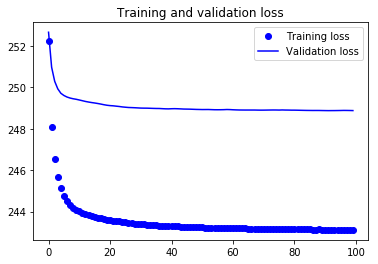

In [475]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(100)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

#autoencoder.save_weights('autoencoder.h5')

In [476]:
# Change the labels from categorical to one-hot encoding
train_Y_one_hot = to_categorical(train_label)
test_Y_one_hot = to_categorical(test_label)

# Display the change for category label using one-hot encoding
print('Original label:', train_label[0])
print('After conversion to one-hot:', train_Y_one_hot[0])

Original label: 3
After conversion to one-hot: [0. 0. 0. 1. 0. 0.]


In [477]:
train_X,valid_X,train_label,valid_label = train_test_split(train_data,train_Y_one_hot,test_size=0.2,random_state=13)
train_X.shape,valid_X.shape,train_label.shape,valid_label.shape

((194, 6, 512, 1), (49, 6, 512, 1), (194, 6), (49, 6))

In [0]:
def fc(enco):
  flat = Flatten()(enco)
  den = Dense(128, activation='relu')(flat)
  out = Dense(num_classes, activation='softmax')(den)
  return out

In [479]:
for i, layer in enumerate(autoencoder.layers):
  print(f"Layer {i}: {layer}")

Layer 0: <keras.engine.input_layer.InputLayer object at 0x7fd966ba3f98>
Layer 1: <keras.layers.convolutional.Conv2D object at 0x7fd95894fe10>
Layer 2: <keras.layers.advanced_activations.LeakyReLU object at 0x7fd95895f2e8>
Layer 3: <keras.layers.normalization.BatchNormalization object at 0x7fd95895f4e0>
Layer 4: <keras.layers.core.Dropout object at 0x7fd95895fd30>
Layer 5: <keras.layers.pooling.MaxPooling2D object at 0x7fd958972278>
Layer 6: <keras.layers.convolutional.Conv2D object at 0x7fd95877a2b0>
Layer 7: <keras.layers.advanced_activations.LeakyReLU object at 0x7fd9586d14e0>
Layer 8: <keras.layers.normalization.BatchNormalization object at 0x7fd9586d1d68>
Layer 9: <keras.layers.core.Dropout object at 0x7fd9586d1978>
Layer 10: <keras.layers.pooling.MaxPooling2D object at 0x7fd95865d4a8>
Layer 11: <keras.layers.convolutional.Conv2D object at 0x7fd95868fef0>
Layer 12: <keras.layers.advanced_activations.LeakyReLU object at 0x7fd95858de10>
Layer 13: <keras.layers.normalization.BatchNorm

In [0]:
encode = encoder(input_img)
full_model = Model(input_img,fc(encode))
for l1,l2 in zip(full_model.layers[0:18],autoencoder.layers[0:18]):
    l1.set_weights(l2.get_weights())
    
for layer in full_model.layers[0:18]:
    layer.trainable = False

In [481]:
full_model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(lr=0.01),metrics=['accuracy']) #0.1
full_model.summary()

Model: "model_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_43 (InputLayer)        (None, 6, 512, 1)         0         
_________________________________________________________________
conv2d_827 (Conv2D)          (None, 6, 512, 32)        320       
_________________________________________________________________
leaky_re_lu_400 (LeakyReLU)  (None, 6, 512, 32)        0         
_________________________________________________________________
batch_normalization_717 (Bat (None, 6, 512, 32)        128       
_________________________________________________________________
dropout_102 (Dropout)        (None, 6, 512, 32)        0         
_________________________________________________________________
max_pooling2d_136 (MaxPoolin (None, 3, 256, 32)        0         
_________________________________________________________________
conv2d_828 (Conv2D)          (None, 3, 256, 64)        184

In [482]:
classify_train = full_model.fit(train_X, train_label, batch_size=64,epochs=100,verbose=1,validation_data=(valid_X, valid_label))
full_model.save_weights('autoencoder_classification.h5')

Train on 194 samples, validate on 49 samples
Epoch 1/100
194/194 [==============================] - 30s 155ms/step - loss: 0.2292 - acc: 0.2113 - val_loss: 0.2854 - val_acc: 0.1429
Epoch 2/100
194/194 [==============================] - 0s 792us/step - loss: 0.2553 - acc: 0.2320 - val_loss: 0.2653 - val_acc: 0.2041
Epoch 3/100
194/194 [==============================] - 0s 742us/step - loss: 0.2609 - acc: 0.2165 - val_loss: 0.2585 - val_acc: 0.2245
Epoch 4/100
194/194 [==============================] - 0s 720us/step - loss: 0.2591 - acc: 0.2216 - val_loss: 0.2789 - val_acc: 0.1633
Epoch 5/100
194/194 [==============================] - 0s 698us/step - loss: 0.2593 - acc: 0.2216 - val_loss: 0.2785 - val_acc: 0.1633
Epoch 6/100
194/194 [==============================] - 0s 692us/step - loss: 0.2526 - acc: 0.2423 - val_loss: 0.2777 - val_acc: 0.1633
Epoch 7/100
194/194 [==============================] - 0s 684us/step - loss: 0.2509 - acc: 0.2474 - val_loss: 0.2856 - val_acc: 0.1429
Epoch 8/1

In [0]:
for layer in full_model.layers[0:18]:
    layer.trainable = True
    
full_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(lr=0.0001),metrics=['accuracy'])

In [487]:
classify_train = full_model.fit(train_X, train_label, batch_size=64,epochs=100,verbose=1,validation_data=(valid_X, valid_label))
full_model.save_weights('classification_complete.h5')

Train on 194 samples, validate on 49 samples
Epoch 1/100
194/194 [==============================] - 31s 160ms/step - loss: 13.1271 - acc: 0.1856 - val_loss: 14.4734 - val_acc: 0.1020
Epoch 2/100
194/194 [==============================] - 0s 1ms/step - loss: 12.8779 - acc: 0.2010 - val_loss: 14.4734 - val_acc: 0.1020
Epoch 3/100
194/194 [==============================] - 0s 1ms/step - loss: 13.2933 - acc: 0.1753 - val_loss: 14.4734 - val_acc: 0.1020
Epoch 4/100
194/194 [==============================] - 0s 1ms/step - loss: 12.9609 - acc: 0.1959 - val_loss: 14.4734 - val_acc: 0.1020
Epoch 5/100
194/194 [==============================] - 0s 1ms/step - loss: 13.0700 - acc: 0.1856 - val_loss: 14.4734 - val_acc: 0.1020
Epoch 6/100
194/194 [==============================] - 0s 1ms/step - loss: 12.9609 - acc: 0.1959 - val_loss: 14.4734 - val_acc: 0.1020
Epoch 7/100
194/194 [==============================] - 0s 1ms/step - loss: 13.0440 - acc: 0.1907 - val_loss: 14.4734 - val_acc: 0.1020
Epoch 8

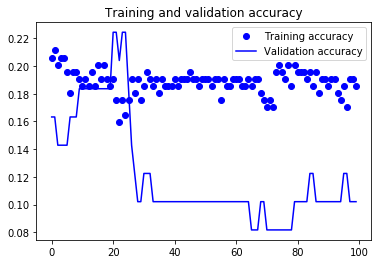

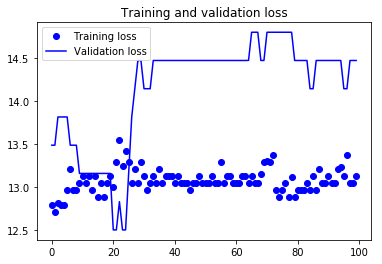

In [485]:
accuracy = classify_train.history['acc']
val_accuracy = classify_train.history['val_acc']
loss = classify_train.history['loss']
val_loss = classify_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [297]:
test_eval = full_model.evaluate(test_data, test_Y_one_hot, verbose=0)

print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.284153017352839
Test accuracy: 0.14754098336227606


In [268]:
predicted_classes = full_model.predict(test_data)
print(predicted_classes.shape)

(61, 6)


In [269]:
predicted_classes1 = np.argmax(predicted_classes, axis=1)
print(predicted_classes1)

[1 2 4 1 1 2 4 4 4 1 4 2 2 5 2 1 5 2 4 2 2 1 2 5 2 4 4 0 4 2 2 1 2 1 4 2 1
 2 3 1 0 2 4 0 1 2 2 1 0 2 4 1 0 1 1 4 0 1 2 1 1]
